## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,ENGLISH_STOP_WORDS
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

sns.set(style="whitegrid")
%matplotlib inline

## Read in data

In [2]:
# Original dataframe before modeling
orig_df = pd.read_csv('../data/fin_data_101519.csv')
orig_df['text'] = orig_df['text'].apply(lambda x: x.lower())

# Dataframe after vectorizing
cvec_df = pd.read_csv('../data/model_data/cvec_df.csv')
tvec_df = pd.read_csv('../data/model_data/tvec_df.csv')

# Dataframe of each word's frequency
cvec_freq = pd.read_csv('../data/model_data/all_stopwords_cvec.csv').rename({'Unnamed: 0':'words'}, axis=1)

# Dataframe of each word's coefficient
cvec_coef = pd.read_csv('../data/model_data/coef_df_cvec.csv')
tvec_coef = pd.read_csv('../data/model_data/coef_df_tvec.csv')

In [4]:
# Dataframe of each word's frequency rate
words = []
spot_count = []
app_count = []

tvec_words = list(tvec_coef['words'])

total_spot_post = orig_df.loc[orig_df['target']==1].shape[0]
total_app_post = orig_df.loc[orig_df['target']==0].shape[0]

for word in tvec_words:
    words.append(word)
    spot_count.append(orig_df[(orig_df['text'].\
                               str.contains(word)) & (orig_df['target']==1)].shape[0]/total_spot_post * 100)
    app_count.append(orig_df[(orig_df['text'].\
                              str.contains(word)) & (orig_df['target']==0)].shape[0]/total_app_post * 100)

out_dic = {'words': words,
           'spotify': spot_count,
           'apple': app_count}

tvec_freq = pd.DataFrame(out_dic)
tvec_freq['diff'] = tvec_freq['spotify'] - tvec_freq['apple']
tvec_freq['abs_diff'] = abs(tvec_freq['spotify'] - tvec_freq['apple'])

## Functions

In [5]:
def what_post(word):
    """
    Return rows of 'orig_df' that 'word' is included in text
    
    Parameters
    word: str or list
    """
    if type(word) == str:
        return orig_df[(orig_df['text'].str.contains(word))]
    if type(word) == list:
        return orig_df[orig_df['text'].str.contains('|'.join(word))]

In [6]:
def who_post(word):
    """
    Return a dataframe of how many percentage of posts in each subreddit
        contain 'word'
    
    Parameters
    word: str or list
    """
    dist = what_post(word).groupby('target').count()[['text']].T
    dist[0] = dist[0] / total_app_post * 100
    dist[1] = dist[1] / total_spot_post * 100
    return dist.rename({'text':'percentage'})

In [7]:
def what_coef(word):
    """
    Return a dataframe of coefficient and exponent of coefficient of 'word' or all elements in 'word'
        contain 'word'
    
    Parameters
    word: str or list
    """    
    
    return tvec_coef.loc[tvec_coef['words'].isin(word)].sort_values('exp_coef', ascending=False) 

In [8]:
def what_freq(word):
    return tvec_freq[tvec_freq['words'].isin(word)]

---
### EDA (Exploratory Data Analysis)

In [9]:
bug_words = ['errors','bugs','bug','error','issues','issue']
bug_word_test_df = what_post(bug_words)

In [10]:
# among peole who have issues with the software, quarter of them are talking about itunes
bug_words = ['errors','bugs','bug','error','issues','issue']

bug_word_df = who_post(bug_words).rename(
{0: "Apple Music",
 1: "Spotify"}, axis=1)

In [23]:
bug_word_df

target,Apple Music,Spotify
percentage,10.823654,4.6706


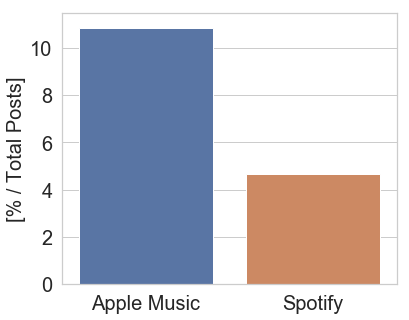

In [21]:
# Percentage of Posts About Technical issues by subreddits

plt.figure(figsize=(6,5))

ax = sns.barplot(x= bug_word_df.columns , y = bug_word_df.loc['percentage'])

ax.set_xlabel('')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0,11.5)
ax.set_ylabel('[% / Total Posts]', fontsize=20)
# plt.savefig('./image/tech_issue_1.png')

**Observation:**
- 11 percent of the Apple Music subreddit talks about errors/issues.
- 5 percent of Spotify subreddit talk about errors/issues.
--> This suggests that more Apple Music users experience issues that they need to reach out to the public about than Spotify users.

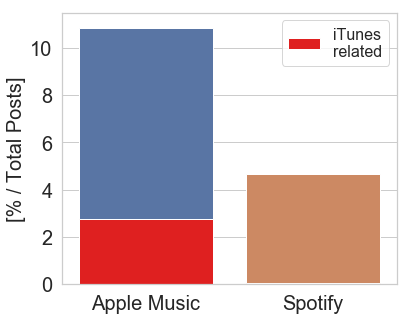

In [22]:
# Percentage of Posts About Technical issues by subreddits + percentage of itunes issue

plt.figure(figsize=(6,5))

ax = sns.barplot(x= bug_word_df.columns , y = bug_word_df.loc['percentage'])

# Make the proportion of the plot where itunes is mentioned
ax = sns.barplot(x= bug_word_df.columns,
                 y = [bug_word_df.loc['percentage'][0]/(205/52),
                      bug_word_df.loc['percentage'][1]/(95)], color='red', label='iTunes\nrelated')

ax.set_xlabel('')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0,11.5)
ax.set_ylabel('[% / Total Posts]', fontsize=20)
plt.legend(fontsize=16)
plt.savefig('./image/tech_issue_2.png')

**Observation:**
- About quarter (52 out of 205) of all Apple Music posts about technical issue was about itunes.


In [13]:
genres= ['country', 'edm', 'jazz', 'rock', 
         'metal', 'techno','trance',
         'rap', 'instrumental', 'pop',
         'electronic','indie', 'blues',
         'soul','latin']

In [14]:
genre_by_subred = who_post(genres).rename(
{0: "Apple Music",
 1: "Spotify"}, axis=1)

In [15]:
genre_by_subred

target,Apple Music,Spotify
percentage,13.621964,25.172075


Text(0, 0.5, '[% / Total Posts]')

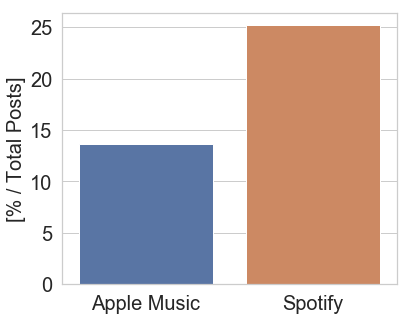

In [16]:
# Percentage of Posts About Technical issues by subreddits

plt.figure(figsize=(6,5))
ax = sns.barplot(x= genre_by_subred.columns , y = genre_by_subred.loc['percentage'])
ax.set_xlabel('')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_ylabel('[% / Total Posts]', fontsize=20)

**Observation:**
- Genre is being talked about more on Spotify than on Apple Music by 10 percent.

In [17]:
genre_freq = what_freq(genres).sort_values('diff',ascending =False)

Text(0, 0.5, '')

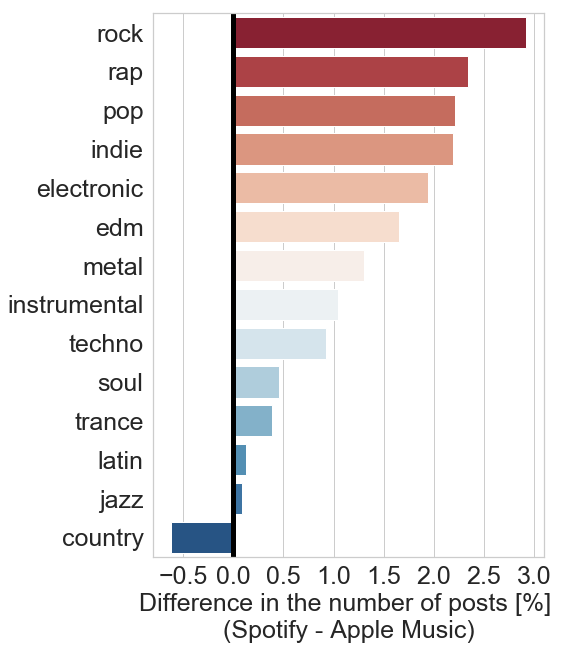

In [18]:
#Plot: freqency of the "posts" that included these words
fig = plt.figure(figsize=(7,10))
ax = sns.barplot(y= 'words', x = 'diff', data= genre_freq, palette ="RdBu")
plt.axvline(0, color='black', linewidth = 5)
plt.xlabel("Difference in the number of posts [%] \n(Spotify - Apple Music)", fontsize=25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
ax.set_ylabel('') 

**Observation:**
- Rock, Rap, pop, indie, electronic, edm are being talked about on Spotify reddits.
- Jazz and Latin are being talked about on both reddits at about the same rate.
- Country music is being talked about more by Apple Music reddit users.

In [19]:
genre_coef = what_coef(genres)

Text(0, 0.5, '')

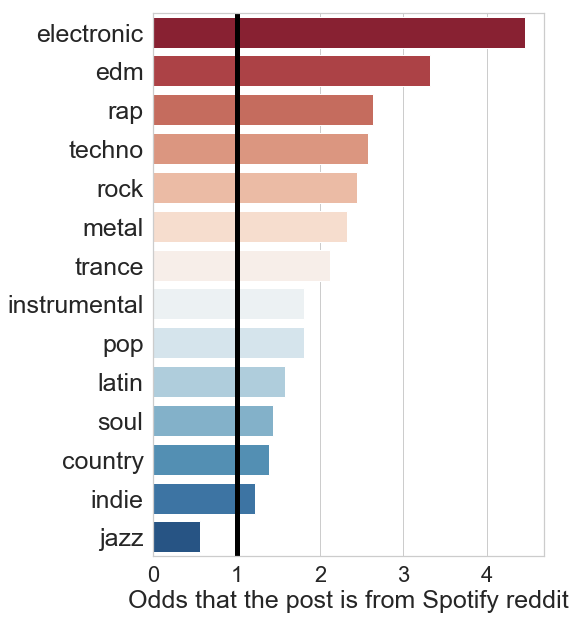

In [20]:
#Plot: coefficient of "words" that included these words

fig=plt.figure(figsize=(7,10))
ax = sns.barplot(y= 'words', x = 'exp_coef', data= genre_coef, palette ="RdBu")
plt.axvline(1, color='black', linewidth = 5)
plt.xlabel("Odds that the post is from Spotify reddit", fontsize=25)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 25)
ax.set_ylabel('') 
# # words 

**Observation:**
- If the post has any words: rock, rap, pop, indie, electronic, edm, it is likely by Spotify reddits user.
- The word "jazz" is being used by Apple Music redddit users than Spotify reddit users.
    - (Both reddits users made about the same post about the word jazz in it. This is an indicator that Apple Music reddit users might have more in-depth conversation about Jazz)